# Policy Gradient



## Learning Policies Directly

### Constraints on the Policy Parameterization

$$
\begin{gather*}
\pi(a|s,\mathbf{\theta}) \geq 0 & \forall a \in \mathcal{A},s \in \mathcal{S}\\
\sum_{a\in\mathcal{A}}{\pi(a|s,\mathbf{\theta})=1} & \forall s \in \mathcal{S}
\end{gather*}
$$

### The Softmax Policy Parameterization

$$
\pi(a|s,\mathbf{\theta})\doteq\frac{\underbrace{e^{h(s,a,\mathbf{\theta})}}{\text{Action Preference}}}{\sum_{b\in\mathcal{A}}{e^{h(s,b,\mathbf{\theta})}}}
$$


## Advantages of Policy Parameterization

### Parameterized stochastic policies are useful because

- They can autonomously *decrease exploration* over time
- They can avoid failures due to deterministic policies with *limited function approximation*
- Sometimes the policy is less complicated than the value function

## The Objective for Learning Policies

### The Average Reward Objective

$$
r(\pi)=\underbrace{\sum_{s}\mu(s)\underbrace{\sum_{a}\pi(a|s,\mathbf{\theta})\underbrace{\sum_{s',r}p(s',r|s,a)r}_{\mathbb{E}[R_t|S_t=s,A_t=a]}}_{\mathbb{E}_\pi[R_t|S_t=s]}}_{\mathbb{E}_\pi[R_t]}
$$

### Optimizing The Average Reward Objective

- Policy-Gradient Method

$$
\nabla r(\pi)=\nabla\sum_{s}\mu(s)\sum_{a}\pi(a|s,\mathbf{\theta})\sum_{s',r}p(s',r|s,a)r
$$

### The Challenge of Policy Gradient Methods

- We can use the average reward as an objective for policy optimization

$$
\nabla_\mathbf{\theta} r(\pi)=\nabla_\mathbf{\theta}\sum_{s}\underbrace{\mu(s)}_{\text{Depends on }\mathbf{\theta}}\sum_{a}\pi(a|s,\mathbf{\theta})\sum_{s',r}p(s',r|s,a)r
$$

$$
\begin{align*}
\nabla_\mathbf{w}\overline{VE} &= \nabla_\mathbf{w}\sum_{s}\mu(s)[v_\pi(s)-\hat{v}(s,\mathbf{w})]^2 \\
                               &= \sum_{s}\mu(s)\nabla_\mathbf{w}[v_\pi(s)-\hat{v}(s,\mathbf{w})]^2
\end{align*}
$$



## Example: Short corridor with switched actions

In [8]:
#######################################################################
# Copyright (C)                                                       #
# 2018 Sergii Bondariev (sergeybondarev@gmail.com)                    #
# 2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

def true_value(p):
    """ True value of the first state
    Args:
        p (float): probability of the action 'right'.
    Returns:
        True value of the first state.
        The expression is obtained by manually solving the easy linear system
        of Bellman equations using known dynamics.
    """
    return (2 * p - 4) / (p * (1 - p))

class ShortCorridor:
    """
    Short corridor environment, see Example 13.1
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.state = 0

    def step(self, go_right):
        """
        Args:
            go_right (bool): chosen action
        Returns:
            tuple of (reward, episode terminated?)
        """
        if self.state == 0 or self.state == 2:
            if go_right:
                self.state += 1
            else:
                self.state = max(0, self.state - 1)
        else:
            if go_right:
                self.state -= 1
            else:
                self.state += 1

        if self.state == 3:
            # terminal state
            return 0, True
        else:
            return -1, False

def softmax(x):
    t = np.exp(x - np.max(x))
    return t / np.sum(t)

class ReinforceAgent:
    """
    ReinforceAgent that follows algorithm
    'REINFORNCE Monte-Carlo Policy-Gradient Control (episodic)'
    """
    def __init__(self, alpha, gamma):
        # set values such that initial conditions correspond to left-epsilon greedy
        self.theta = np.array([-1.47, 1.47])
        self.alpha = alpha
        self.gamma = gamma
        # first column - left, second - right
        self.x = np.array([[0, 1],
                           [1, 0]])
        self.rewards = []
        self.actions = []

    def get_pi(self):
        h = np.dot(self.theta, self.x)
        t = np.exp(h - np.max(h))
        pmf = t / np.sum(t)
        # never become deterministic,
        # guarantees episode finish
        imin = np.argmin(pmf)
        epsilon = 0.05

        if pmf[imin] < epsilon:
            pmf[:] = 1 - epsilon
            pmf[imin] = epsilon

        return pmf

    def get_p_right(self):
        return self.get_pi()[1]

    def choose_action(self, reward):
        if reward is not None:
            self.rewards.append(reward)

        pmf = self.get_pi()
        go_right = np.random.uniform() <= pmf[1]
        self.actions.append(go_right)

        return go_right

    def episode_end(self, last_reward):
        self.rewards.append(last_reward)

        # learn theta
        G = np.zeros(len(self.rewards))
        G[-1] = self.rewards[-1]

        for i in range(2, len(G) + 1):
            G[-i] = self.gamma * G[-i + 1] + self.rewards[-i]

        gamma_pow = 1

        for i in range(len(G)):
            j = 1 if self.actions[i] else 0
            pmf = self.get_pi()
            grad_ln_pi = self.x[:, j] - np.dot(self.x, pmf)
            update = self.alpha * gamma_pow * G[i] * grad_ln_pi

            self.theta += update
            gamma_pow *= self.gamma

        self.rewards = []
        self.actions = []

class ReinforceBaselineAgent(ReinforceAgent):
    def __init__(self, alpha, gamma, alpha_w):
        super(ReinforceBaselineAgent, self).__init__(alpha, gamma)
        self.alpha_w = alpha_w
        self.w = 0

    def episode_end(self, last_reward):
        self.rewards.append(last_reward)

        # learn theta
        G = np.zeros(len(self.rewards))
        G[-1] = self.rewards[-1]

        for i in range(2, len(G) + 1):
            G[-i] = self.gamma * G[-i + 1] + self.rewards[-i]

        gamma_pow = 1

        for i in range(len(G)):
            self.w += self.alpha_w * gamma_pow * (G[i] - self.w)

            j = 1 if self.actions[i] else 0
            pmf = self.get_pi()
            grad_ln_pi = self.x[:, j] - np.dot(self.x, pmf)
            update = self.alpha * gamma_pow * (G[i] - self.w) * grad_ln_pi

            self.theta += update
            gamma_pow *= self.gamma

        self.rewards = []
        self.actions = []

def trial(num_episodes, agent_generator):
    env = ShortCorridor()
    agent = agent_generator()

    rewards = np.zeros(num_episodes)
    for episode_idx in range(num_episodes):
        rewards_sum = 0
        reward = None
        env.reset()

        while True:
            go_right = agent.choose_action(reward)
            reward, episode_end = env.step(go_right)
            rewards_sum += reward

            if episode_end:
                agent.episode_end(reward)
                break

        rewards[episode_idx] = rewards_sum

    return rewards

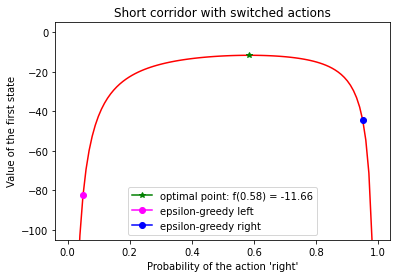

In [9]:
epsilon = 0.05
fig, ax = plt.subplots(1, 1)

# Plot a graph
p = np.linspace(0.01, 0.99, 100)
y = true_value(p)
ax.plot(p, y, color='red')

# Find a maximum point, can also be done analytically by taking a derivative
imax = np.argmax(y)
pmax = p[imax]
ymax = y[imax]
ax.plot(pmax, ymax, color='green', marker="*", label="optimal point: f({0:.2f}) = {1:.2f}".format(pmax, ymax))

# Plot points of two epsilon-greedy policies
ax.plot(epsilon, true_value(epsilon), color='magenta', marker="o", label="epsilon-greedy left")
ax.plot(1 - epsilon, true_value(1 - epsilon), color='blue', marker="o", label="epsilon-greedy right")

ax.set_ylabel("Value of the first state")
ax.set_xlabel("Probability of the action 'right'")
ax.set_title("Short corridor with switched actions")
ax.set_ylim(ymin=-105.0, ymax=5)
ax.legend()

## The Policy Gradient Theorem

### The Gradient of the Objective

$$
\begin{align*}
\nabla r(\pi) &= \nabla\sum_{s}\mu(s)\sum_{a}\pi(a|s,\mathbf{\theta})\sum_{s',r}p(s',r|s,a)r \\
              &= \sum_{s}\nabla\mu(s)\sum_{a}\pi(a|s,\mathbf{\theta})\sum_{s',r}p(s',r|s,a)r + \sum_{s}\mu(s)\nabla\sum_{a}\pi(a|s,\theta)\sum_{s',r}p(s',r|s,a)r
\end{align*}
$$

### The Policy Gradient Theorem

- The *policy gradient theorem* gives an expression for the gradient of the average reward

$$
\nabla r(\pi) = \sum_{s}\mu(s)\sum_{a}\nabla \pi(a|s,\theta)q_\pi(s,a)
$$



## Estimating the Policy Gradient

### Getting Stochastic Samples of the Gradient

$$
\begin{gather*}
\nabla r(\pi)=\sum_{s}\mu(s)\sum_{a}\nabla \pi(a|s,\mathbf{\theta})q_\pi(s,a)\\
\mathbf{\theta}_{t+1}\doteq\mathbf{\theta}_{t}+\alpha\sum_{a}\nabla\pi(a|S_t,\mathbf{\theta}_t)q_\pi(S_t,a)\\
\\
S_0,A_0,R_1,S_1,A_1,\ldots,S_t,A_t,R_{t+1},\ldots
\end{gather*}
$$

### Unbiasedness of the Stochastic Samples

$$
\begin{align*}
\nabla r(\pi) &=\sum_{s}\mu(s)\sum_{a}\nabla\pi(a|s,\mathbf{\theta})q_\pi(s,a)\\
              &=\mathbb{E}_\mu[\sum_{a}\nabla\pi(a|S,\mathbf{\theta})q_\pi(S,a)]
\end{align*}
$$

### Getting Stochastic Samples with One Action

$$
\begin{align*}
&\sum_{a}\nabla\pi(a|S,\mathbf{\theta})q_\pi(S,a)\\
&=\sum_{a}\pi(a|S,\mathbf{\theta})\frac{1}{\pi(a|S,\mathbf{\theta})}\nabla\pi(a|S,\mathbf{\theta})q_\pi(S,a)\\
&=\mathbb{E}_\pi[\frac{\nabla\pi(A|S,\mathbf{\theta})}{\pi(A|S,\mathbf{\theta})}q_\pi(S,A)]
\end{align*}
$$

### Stochastic Gradient Ascent for Policy Parameters

$$
\begin{align*}
\mathbf{\theta}_{t+1}&\doteq\mathbf{\theta}_{t}+\alpha\frac{\nabla\pi(A_t|S_t,\mathbf{\theta}_t)}{\pi(A_t|S_t,\mathbf{\theta}_t)}q_\pi(S_t,A_t)\\
            &=\mathbf{\theta}_{t}+\alpha\nabla\ln\pi(A_t|S_t,\mathbf{\theta}_t)q_\pi(S_t,A_t)&(\because \nabla\ln\left(f(x)\right)=\frac{\nabla f(x)}{f(x)})
\end{align*}
$$

### Computing the Update

$$
\mathbf{\theta}_{t+1}=\mathbf{\theta}_{t}+\alpha\underbrace{\nabla\ln\pi(A_t|S_t,\mathbf{\theta}_t)}_{\text{gradient of the policy (computable)}}\underbrace{q_\pi(S_t,A_t)}_{\text{estimate of the differntial valus (computable)}}
$$


## Actor-Critic Algorithm

- It is useful to learn a value function to estimate the gradient for the policy parameters
- The *actor-critic algorithm* implements this idea, with a critic that learns a value function for the actor

### Approximating the Actin Value in the Policy Update

$$
\begin{align*}
\mathbf{\theta}_{t+1} &= \mathbf{\theta}_{t}+\alpha\nabla\ln\pi(A_t|S_t,\mathbf{\theta}_t)q_\pi(S_t,A_t)\\
             &\doteq \mathbf{\theta}_{t}+\alpha\nabla\ln\pi(A_t|S_t,\theta_t)[R_{t+1}-\bar{R}+\hat{v}(S_{t+1}, \mathbf{w})]
\end{align*}
$$

### Subtracting the Current State's Value Estimate

$$
\mathbf{\theta}_{t+1} \doteq \mathbf{\theta}_{t}+\alpha\nabla\ln\pi(A_t|S_t,\mathbf{\theta}_t)[\underbrace{R_{t+1}-\bar{R}+\hat{v}(S_{t+1}, \mathbf{w})-\underbrace{\hat{v}(S_t,\mathbf{w})}_{\text{Does not affect the Expected Update}}}_{\text{TD Error }\delta}]
$$

### Adding a Baseline

$$
\begin{align*}
&\mathbf{E}_\pi[\nabla\ln\pi(A_t|S_t,\theta_t)[R_{t+1}-\bar{R}+\hat{v}(S_{t+1}, \mathbf{w})-\underbrace{\hat{v}(S_t,\mathbf{w})}_{\text{Reduces the update variance}}]|S_t=s]\\
=&\mathbf{E}_\pi[\nabla\ln\pi(A_t|S_t,\theta_t)[R_{t+1}-\bar{R}+\hat{v}(S_{t+1}, \mathbf{w})]|S_t=s]\\
&-\underbrace{\mathbf{E}_\pi[\nabla\ln\pi(A_t|S_t,\theta_t)\hat{v}(S_t,\mathbf{w})|S_t=s]}_{0}
\end{align*}
$$


## Actor-Critic with Softmax Policies

### Recap: Actor-Critic

$$
\begin{align*}
\mathbf{w} &\leftarrow \mathbf{w} + \alpha^\mathbf{w}\delta\nabla\hat{v}(S,\mathbf{w})\\
\mathbf{\theta} &\leftarrow \alpha^\mathbf{\theta}\delta\nabla\ln\pi(A|S,\mathbf{\theta})
\end{align*}
$$

### Policy Update with a Softmax Policy

$$
\begin{gather*}
\mathbf{\theta} \leftarrow \alpha^\mathbf{\theta}\delta\nabla\ln\pi(A|S,\mathbf{\theta})\\
\pi(a|s,\mathbf{\theta})\doteq\frac{e^{h(s,a,\mathbf{\theta})}}{\sum_{b\in\mathcal{A}}e^{h(s,b,\mathbf{\theta})}}
\end{gather*}
$$

### Features of the Action Preference Function

$$
\begin{gather*}
\hat{v}(s,\mathbf{w})\doteq\mathbf{w}^T\mathbf{x}(s)\\
h(s,a,\mathbf{\theta})\doteq\mathbf{\theta}^T\mathbf{x}_h(s,a)
\end{gather*}
$$

### Actor-Critic with a Softmax Policy

$$
\begin{align*}
&\mathbf{w} \leftarrow \mathbf{w} + \alpha^\mathbf{w}\delta\mathbf{x}(S)\\
&\mathbf{\theta} \leftarrow \alpha^\mathbf{\theta}\delta\nabla\ln\pi(A|S,\mathbf{\theta})\\
&\nabla\ln\pi(a|s,\mathbf{\theta})=\mathbf{x}_h(s,a)-\sum_{b}\pi(b|s,\mathbf{\theta})\mathbf{x}_h(s,b)
\end{align*}
$$

## Demonstration with Actor-Critic

### 


## Gaussian Poliies for Continuous Actions

### Gaussian Distribution

$$
p(x)\doteq\frac{1}{\sigma\sqrt{2\pi}}\exp(-\frac{(x-\mu)^2}{2\sigma^2})
$$

### Gaussian Policy

$$
\begin{align*}
&\pi(a|s,\mathbf{\theta})\doteq\frac{1}{\sigma(s,\mathbf{\theta})\sqrt{2\pi}}\exp(-\frac{(x-\mu)^2}{2\sigma^2})\\
&\mu(s,\mathbf{\theta})\doteq\mathbf{\theta}_{\mu}^{T}\mathbf{x}(s)\\
&\sigma(s,\mathbf{\theta})\doteq\exp(\mathbf{\theta}_\sigma^T\mathbf{x}(s))\\
&\mathbf{\theta}\doteq\left[
    \begin{array}{c}
    \mathbf{\theta}_\mu\\
    \mathbf{\theta}_\sigma\\
    \end{array}
\right]
\end{align*}
$$

### Gradient of the Log of the Gaussian Policy

$$
\begin{align*}
&\nabla\ln\pi(a|s,\mathbf{\theta}_\mu)=\frac{1}{\sigma(s,\mathbf{\theta})^2}(a-\mu(s,\mathbf{\theta}))\mathbf{x}(s)\\
&\nabla\ln\pi(a|s,\mathbf{\theta}_\sigma)=\left(\frac{(a-\mu(s,\mathbf{\theta}))^2}{\sigma(s,\mathbf{\theta})^2}-1\right)\mathbf{x}(s)
\end{align*}
$$